# Разведочный анализ данных
Вспомним, что за набор данных был в прошлый раз

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from IPython.core.pylabtools import figsize
figsize(10, 10) # зададим размер картинки
data = pd.read_csv('C:\\StudentsPerformance.csv', sep=',')


Подготовим данные, как в прошлый раз

Добавим целевую переменную. Сдал ли студент экзамен по математике. Как условие поставим проходной балл 60

In [12]:
def math(mathscore):
    if mathscore >= 60:
        return 1
    return 0

data['math pass'] = data['math score'].apply(math)
data = data.drop(['math score'], axis='columns')
data = data.drop(['reading score'], axis='columns')
def ch(gender):
    if gender == 'male':
        return 1
    return 0

data['gender'] = data['gender'].apply(ch)

def cha(race):
    if race == 'group A':
        return 0
    if race == 'group B':
        return 1
    if race == 'group C':
        return 2
    if race == 'group D':
        return 3
    return 4

data['race/ethnicity'] = data['race/ethnicity'].apply(cha)

def chan(edu):
    if edu == 'some college':
        return 0
    if edu == "associate's degree":
        return 1
    if edu == 'high school':
        return 2
    if edu == 'some high school':
        return 3
    if edu == "bachelor's degree":
        return 4
    return 5

data['parental level of education'] = data['parental level of education'].apply(chan)

def chang(lunch):
    if lunch == 'standard':
        return 1
    return 0

data['lunch'] = data['lunch'].apply(chang)

def change(test):
    if test == 'completed':
        return 1
    return 0

data['test preparation course'] = data['test preparation course'].apply(change)

Вот данные

In [13]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,writing score,math pass
0,0,1,4,1,0,74,1
1,0,2,0,1,1,88,1
2,0,1,5,1,0,93,1
3,1,0,1,0,0,44,0
4,1,2,0,1,0,75,1


Поделим выборку

In [14]:
X = data[data.columns[:-1]]
y = data['math pass']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

## Структура данных
Посмотрим на распределения и возможные зависимости признаков.

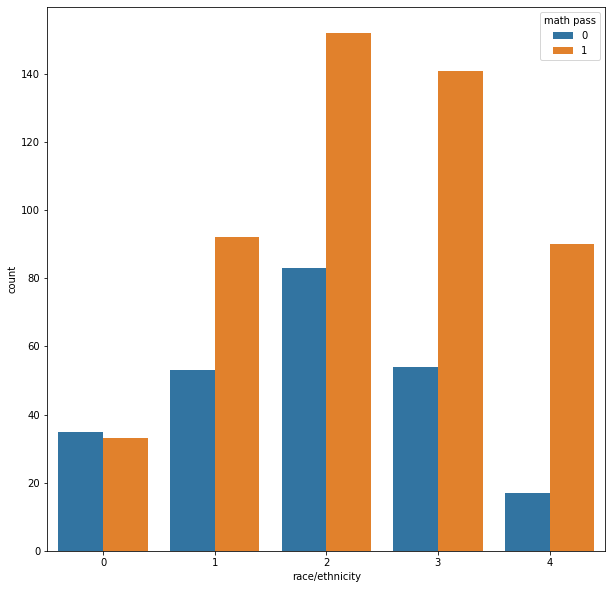

In [15]:
sns.countplot(X_train['race/ethnicity'], hue=y_train)

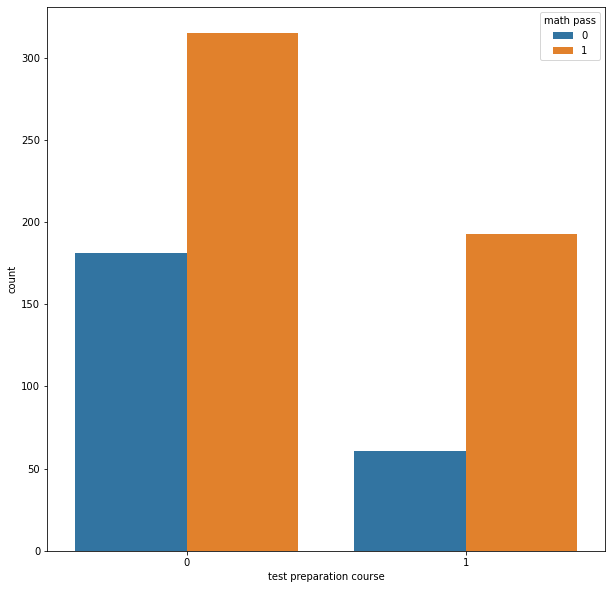

In [16]:
sns.countplot(X_train['test preparation course'], hue=y_train)

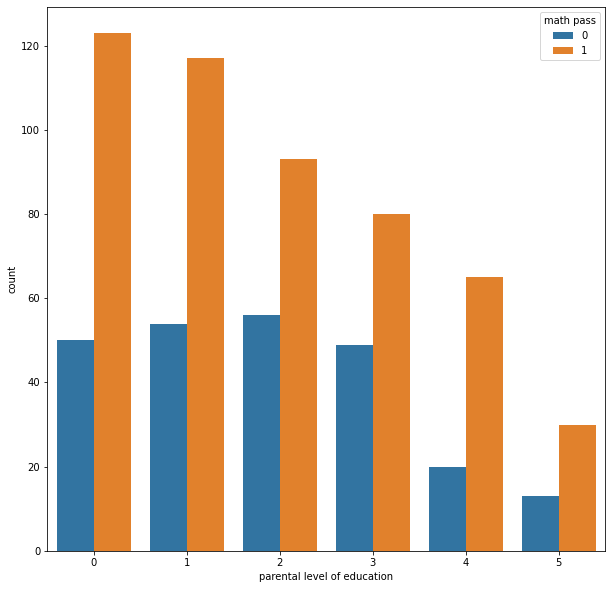

In [18]:
sns.countplot(X_train['parental level of education'], hue=y_train)

Наши переменные не дают точной оценки, прошел ли ученик тест по математике.

#### А как же распределены признаки друг относительно друга?

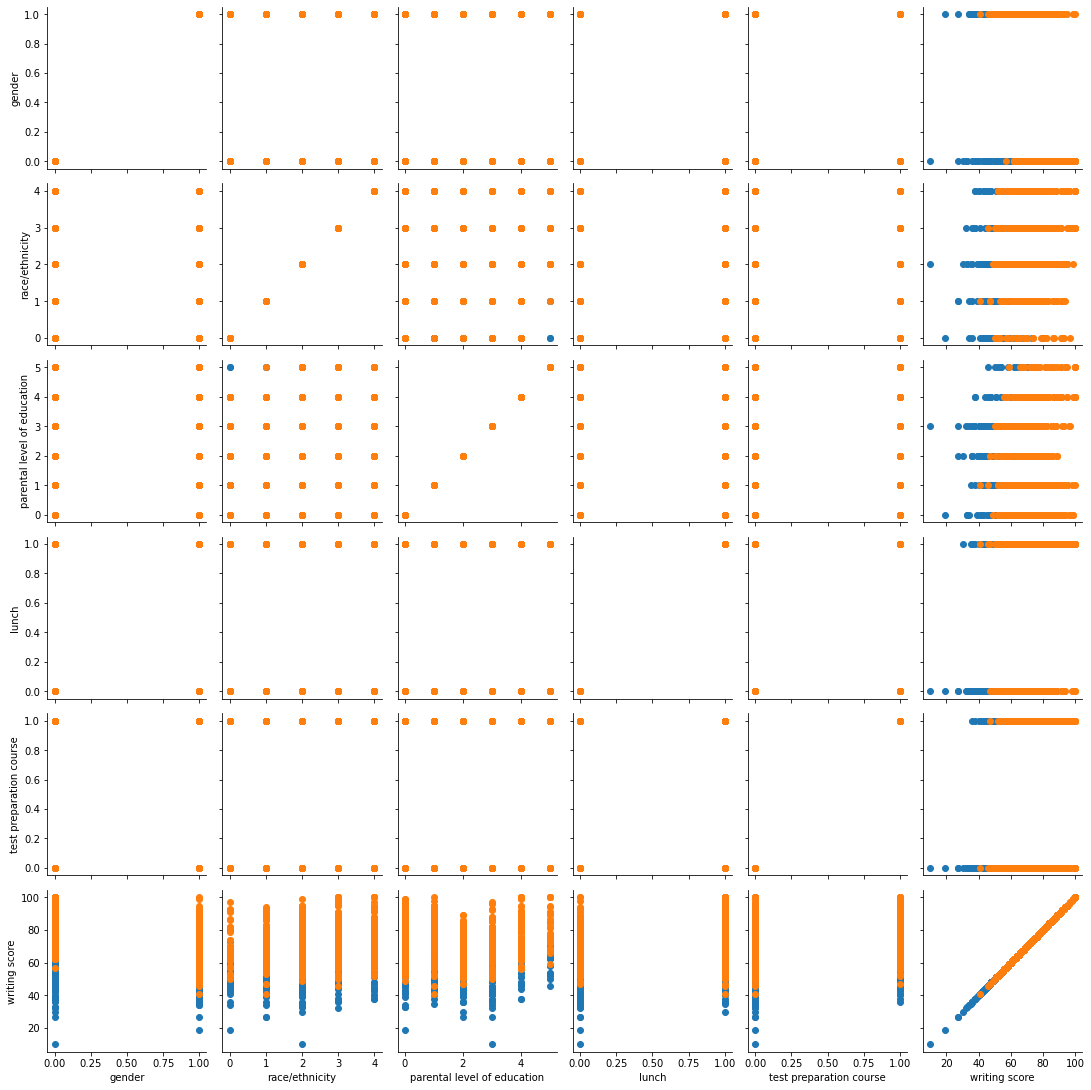

In [19]:
df_for_pairgrid = X_train[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'writing score']]
df_for_pairgrid['math pass'] = y_train

sns.PairGrid(df_for_pairgrid, hue='math pass').map(plt.scatter)

В этом виде легко делать выводы о закономерностях в данных.
В нашем случае зависимостей нет.

### Выбросы

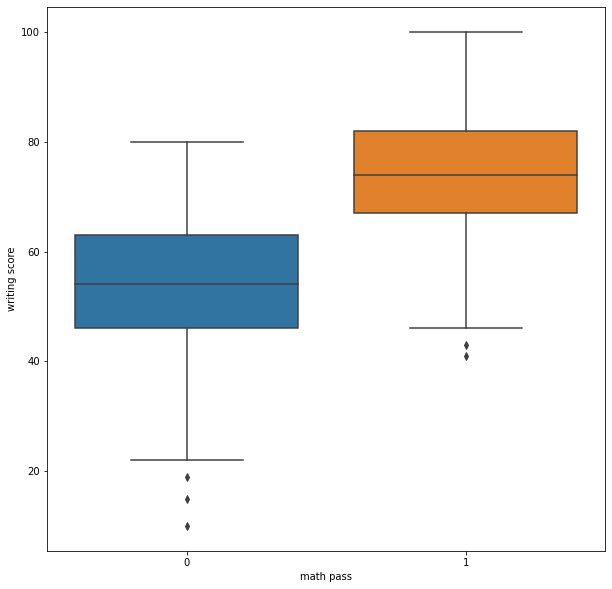

In [23]:
writingscore = pd.read_csv('C:\\StudentsPerformance.csv', sep=',')['writing score'].apply(lambda x: x if x >= 0 else x / 500)
sns.boxplot(x=y, y=writingscore)

А на графике-скрипке можно посмотреть еще и на плотность распределения величины.

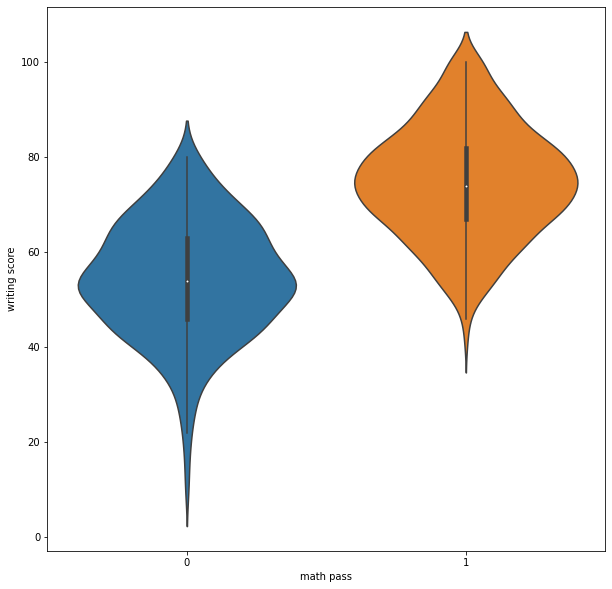

In [24]:
sns.violinplot(x=y, y=writingscore)

## Нормализация признаков

Качество алгоритма до нормализации: 0.864
Качество алгоритма после нормализации: 0.816


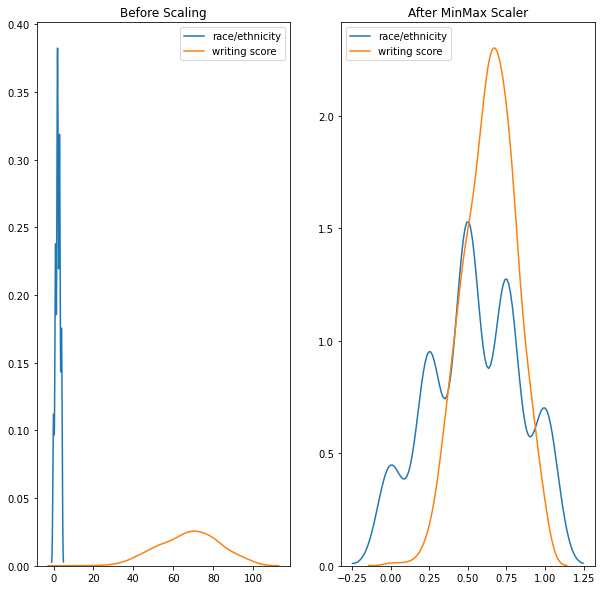

In [25]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

print("Качество алгоритма до нормализации:",
      KNeighborsClassifier(n_neighbors=10).fit(X_train, y_train).score(X_test, y_test))

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, ), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

print("Качество алгоритма после нормализации:",
      KNeighborsClassifier(n_neighbors=10).fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

# графики
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['race/ethnicity'], ax=ax1)
sns.kdeplot(X_train['writing score'], ax=ax1)
ax2.set_title('After MinMax Scaler')
sns.kdeplot(X_train_scaled['race/ethnicity'], ax=ax2)
sns.kdeplot(X_train_scaled['writing score'], ax=ax2)
plt.show()

После нормализации точность предсказаний нашего алгоритма уменьшилась.

## Подбор алгоритма
Не всегда можно понять по визуализации данных, какой алгоритм может хорошо сработать (хотя конкретно в случае этого набора данных выбор очевиден - об этом в следующий раз =) ). Чтобы понять, над какой моделью можно работать, посмотрим на качество на нескольких простых моделях.

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.82
SGDClassifier 0.844
SVC 0.868
GaussianNB 0.856
KNeighborsClassifier 0.8


Метод опорных векторов показал наилучший результат.

## Про стратификацию
Посмотрим на распределение классов в тренировочной выборке.

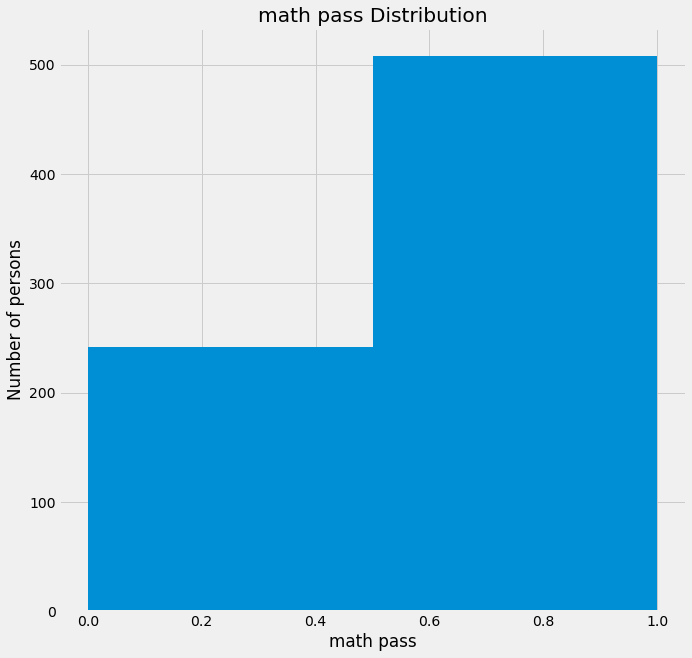

In [27]:
plt.style.use('fivethirtyeight')
plt.hist(y_train, bins=2);
plt.xlabel('math pass'); plt.ylabel('Number of persons');
plt.title('math pass Distribution');

Рассмотрим тупейший случай

In [28]:
from sklearn.metrics import accuracy_score

a = np.ones(y_test.shape[0])
accuracy_score(y_test, a)

0.676

Увеличим количество примеров из недоминантного класса.

In [29]:
X_train_scaled.reset_index(inplace=True, drop=True)
y_train.reset_index(drop=True, inplace=True)
dead = X_train_scaled[y_train == 0]
X_train_strat = pd.concat([X_train_scaled, dead, dead], ignore_index=True)
y_train_strat = pd.concat([y_train, pd.Series(np.ones(X_train_strat.shape[0]-X_train_scaled.shape[0]))],
                          ignore_index=True)
for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_strat, y_train_strat).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.676
SGDClassifier 0.676
SVC 0.676
GaussianNB 0.684
KNeighborsClassifier 0.68


После стратификации лучший результат показал алгоритм Гаусса

# Метрики качества
Посмотрим на предсказания константного классификатора

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, f1_score, fbeta_score, auc

print('Accuracy:', accuracy_score(y_test, a))
print('Precision:', precision_score(y_test, a))
print('Recall:', recall_score(y_test, a))
print('ROC AUC:', roc_auc_score(y_test, a))
pr, rec, _ = precision_recall_curve(y_test, a)
print('PRC AUC:', auc(rec, pr))
print('F1:', f1_score(y_test, a))
print('F0.5:', fbeta_score(y_test, a, 0.5))
print('F2:', fbeta_score(y_test, a, 2))

Accuracy: 0.676
Precision: 0.676
Recall: 1.0
ROC AUC: 0.5
PRC AUC: 0.8380000000000001
F1: 0.8066825775656324
F0.5: 0.7228400342172798
F2: 0.9125269978401729


C:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=0.5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Program Files (x86)\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass beta=2 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
